In [1]:
!pip install pmdarima
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
stock_data = pd.read_csv('dse_cp_BERGERPBL.csv',sep=',', index_col='DATE', parse_dates=['DATE'], date_parser=dateparse).fillna(0)
stock_data
stock_data = stock_data.dropna()
print('shape of data' , stock_data.shape)
stock_data = stock_data.sort_values(by='DATE')
stock_data.head()

shape of data (245, 4)


<ipython-input-2-e8e9872d72ca>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')


,#,TRADING CODE,CLOSEP*,YCP
DATE,,,,
2022-10-16,245,BERGERPBL,"1,719.40","1,719.90"
2022-10-17,244,BERGERPBL,"1,711.60","1,719.40"
2022-10-18,243,BERGERPBL,"1,711.60","1,711.60"
2022-10-19,242,BERGERPBL,"1,712.30","1,711.60"
2022-10-20,241,BERGERPBL,"1,713.30","1,712.30"


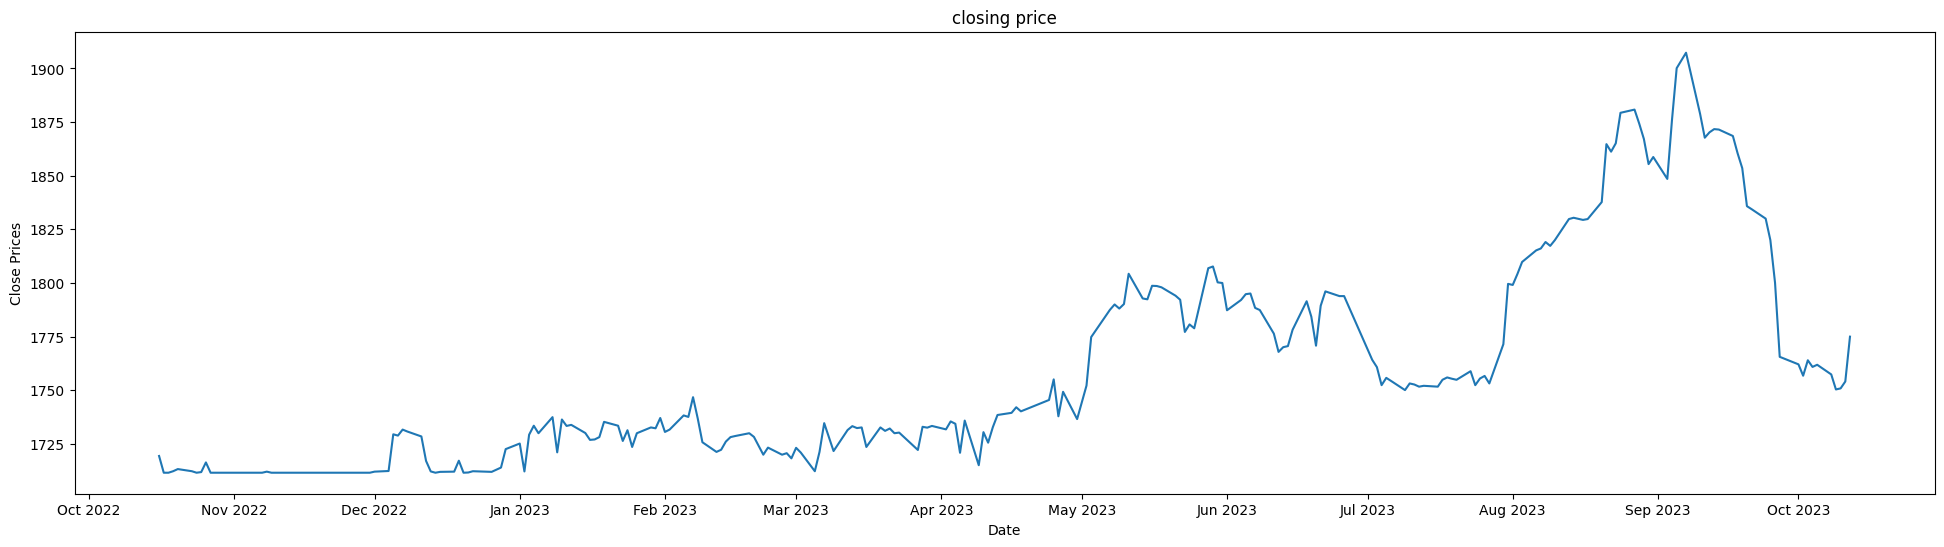

In [10]:
import matplotlib.dates as mdates
plt.figure(figsize=(24,6))

plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['CLOSEP*'])
plt.title('closing price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()

In [4]:
# Replace commas and convert to float
stock_data['CLOSEP*'] = stock_data['CLOSEP*'].str.replace(',', '').astype(float)

In [5]:
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("2. P-value : ",dftest[1])

In [6]:
adf_test(stock_data['CLOSEP*'])

2. P-value :  0.5311347110138906


In [7]:
df_close = stock_data['CLOSEP*']

In [8]:
stock_data['price First Difference'] = df_close - df_close.shift(1)

In [9]:
df_close.shift(1)

DATE
2022-10-16       NaN
2022-10-17    1719.4
2022-10-18    1711.6
2022-10-19    1711.6
2022-10-20    1712.3
               ...  
2023-10-08    1761.9
2023-10-09    1757.4
2023-10-10    1750.4
2023-10-11    1750.9
2023-10-12    1754.1
Name: CLOSEP*, Length: 245, dtype: float64

In [11]:
adf_test(stock_data['price First Difference'].dropna())

2. P-value :  3.130594423304425e-08


<Axes: xlabel='DATE'>

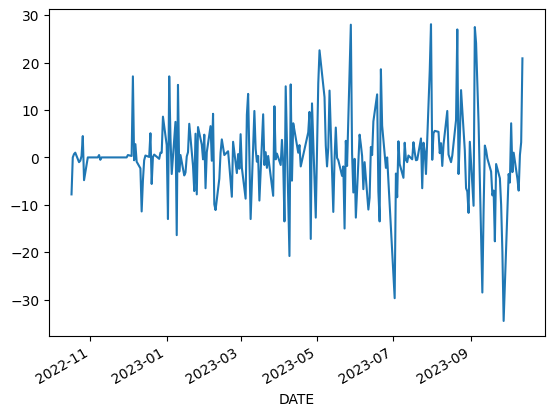

In [12]:
stock_data['price First Difference'].plot()

In [13]:
df_diff=stock_data['price First Difference']

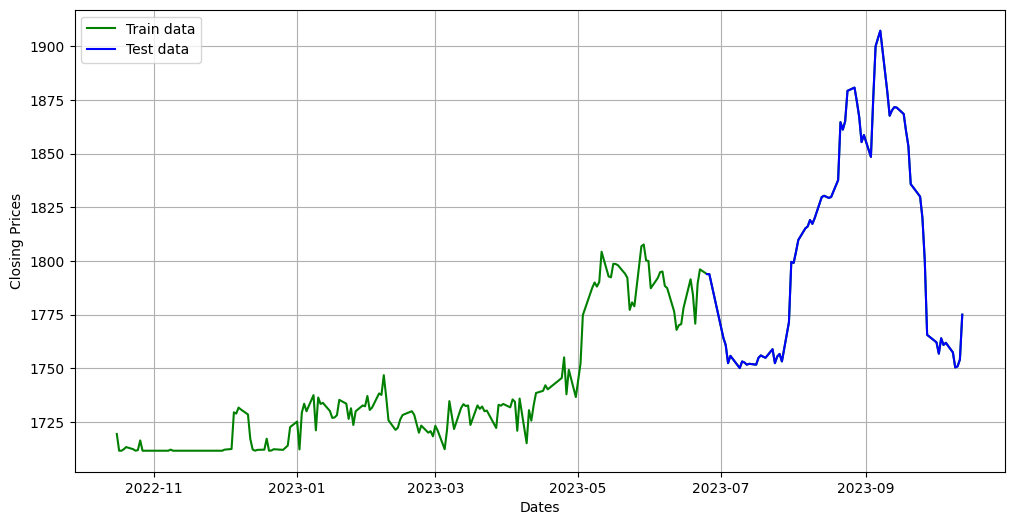

In [20]:
train_data, test_data = df_close[3:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.7):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [21]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_close.dropna(), stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,0))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

DATE
2023-10-12      1
2023-10-11      2
2023-10-10      3
2023-10-09      4
2023-10-08      5
             ... 
2022-10-20    241
2022-10-19    242
2022-10-18    243
2022-10-17    244
2022-10-16    245
Name: #, Length: 245, dtype: int64


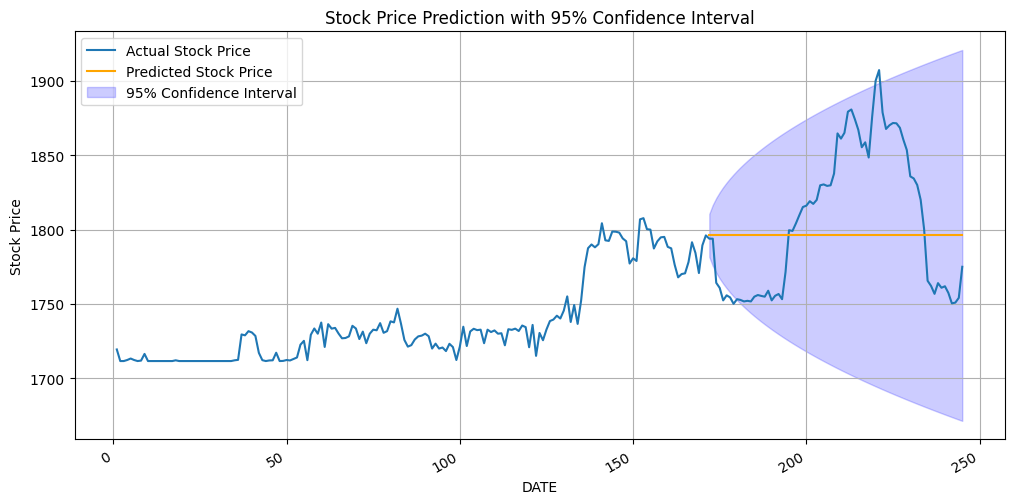

In [23]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

# Calculate indices
total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 49.82035158880789
MAE: 44.14459459459459
MAPE: 0.024252848920903625


## short ***prediction***

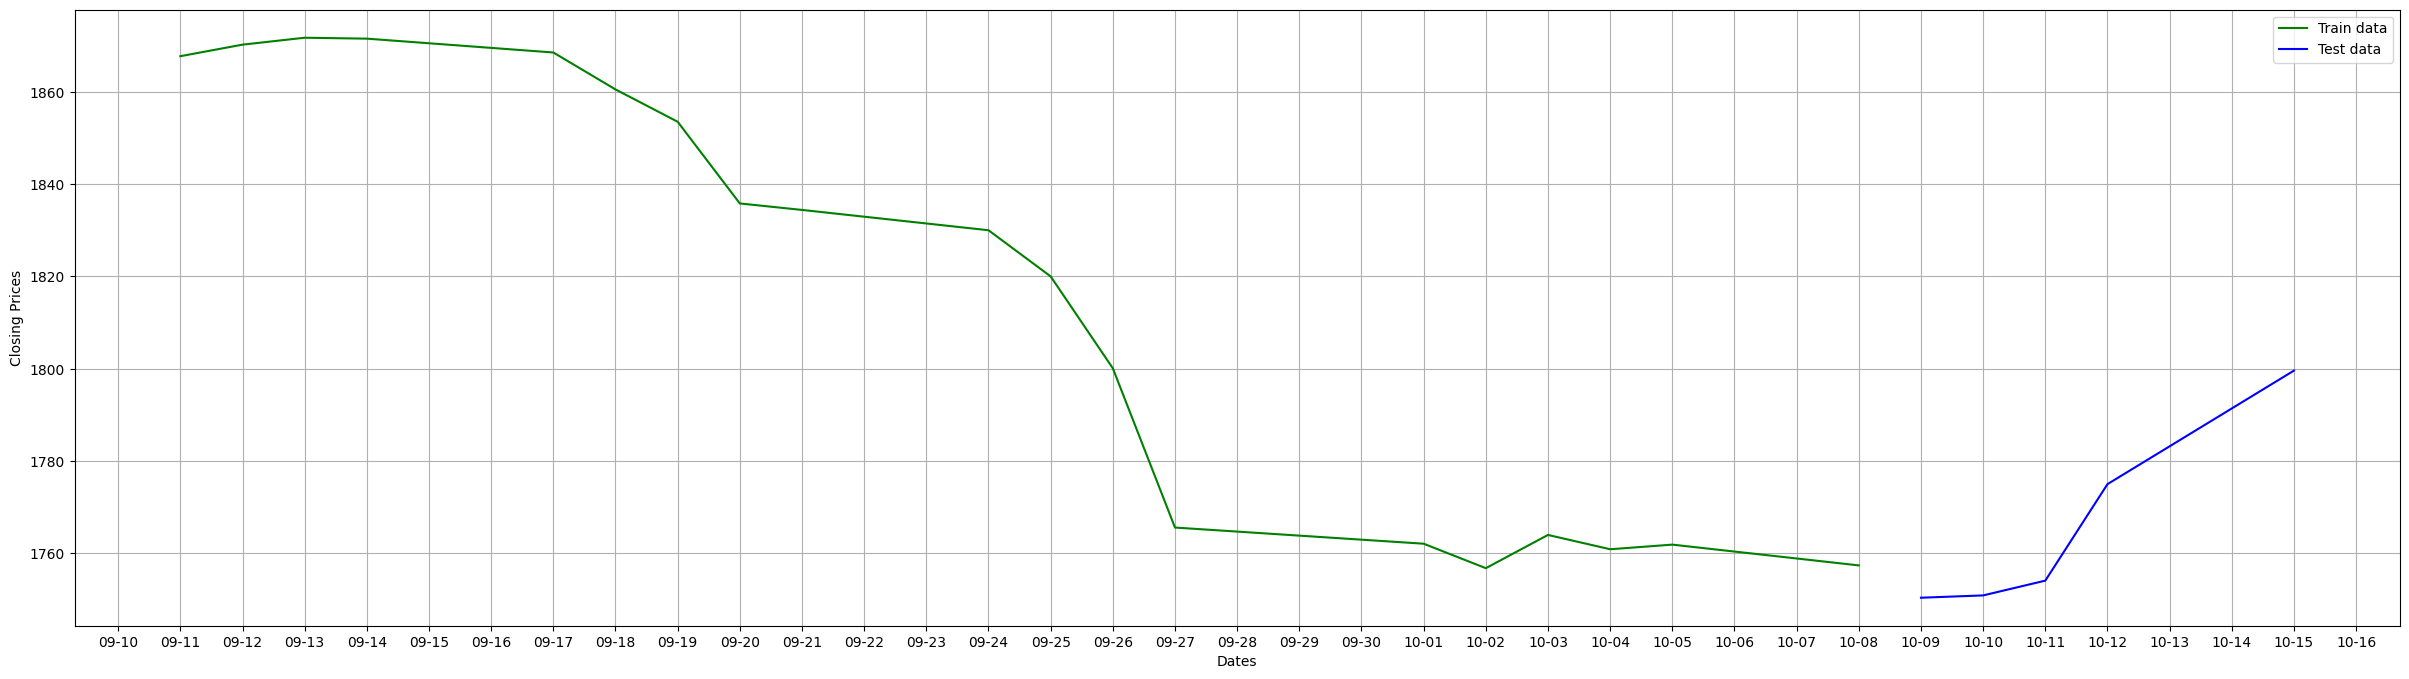

In [ ]:
stock_30 = stock_data[-30:]
last_month = df_close[-30:]
train_data = df_close[-24:-5]
test_data = df_close[-5:]

plt.figure(figsize=(30, 8))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')

date_format = mdates.DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend()

In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(last_month, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(4,1,0))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<ipython-input-57-e78ec5f458b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_30.sort_values(by='#', inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments wil

DATE
2022-11-24    217
2022-11-23    218
2022-11-22    219
2022-11-21    220
2022-11-20    221
2022-11-17    222
2022-11-16    223
2022-11-15    224
2022-11-14    225
2022-11-13    226
2022-11-10    227
2022-11-09    228
2022-11-08    229
2022-11-07    230
2022-11-06    231
2022-11-03    232
2022-11-02    233
2022-11-01    234
2022-10-31    235
2022-10-30    236
2022-10-27    237
2022-10-26    238
2022-10-25    239
2022-10-24    240
2022-10-23    241
2022-10-20    242
2022-10-19    243
2022-10-18    244
2022-10-17    245
2022-10-16    246
Name: #, dtype: int64


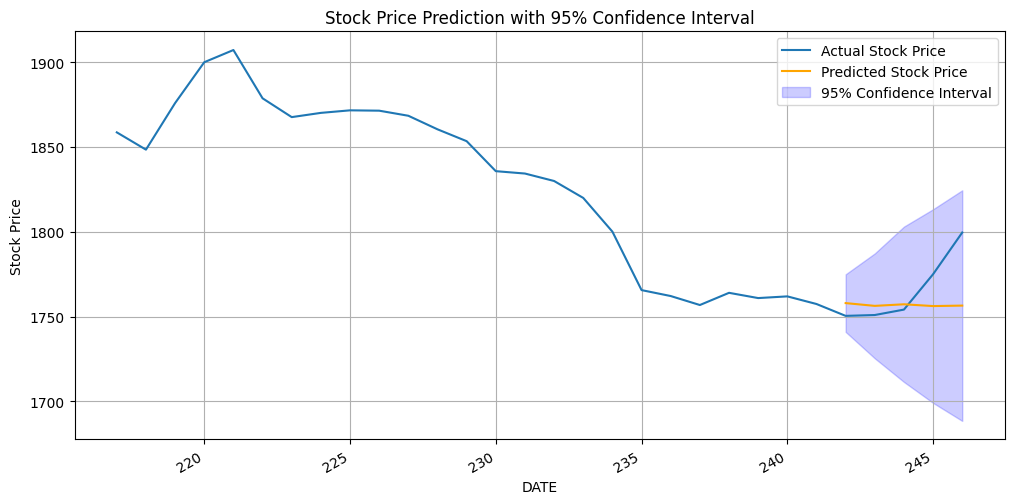

In [ ]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_30.sort_values(by='#', inplace=True)

# Calculate indices
total = len(last_month)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_30['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, last_month.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 21.497619663985347
MAE: 15.604733070435259
MAPE: 0.008749467126315986
